In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


def load_fashion_mnist():
    """
    Loads Fashion MNIST dataset.
    
    Adapted from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'    
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    with gzip.open(TRAIN_LABELS, 'rb') as tr_labels_file, gzip.open(TEST_LABELS, 'rb') as ts_labels_file:
        train_labels = np.frombuffer(tr_labels_file.read(), dtype=np.uint8, offset=8)
        test_labels = np.frombuffer(ts_labels_file.read(), dtype=np.uint8, offset=8)

    with gzip.open(TRAIN_IMAGES, 'rb') as tr_images_file, gzip.open(TEST_IMAGES, 'rb') as ts_images_file:
        train_images = np.frombuffer(tr_images_file.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
        test_images = np.frombuffer(ts_images_file.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)

    return train_images, train_labels, test_images, test_labels

In [2]:
def pretty_print(image_example):
    """ Pretty prints a Fashion MNIST example.

    Parameters:
        image_example: a 1x784 numpy array corresponding to the features of
                       a single image.

    Returns:
        None.
    """
    print(np.array_str(image_example, precision=1, max_line_width=116))


In [3]:
def usage_example():
    """ Example of how to load and parse Fashion MNIST data. """
    
    train_images, train_labels, test_images, test_labels = load_fashion_mnist()

    # train_images is a 60,000 x 784 numpy matrix. There are 60k
    # rows in the matrix, each row corresponding to a single example.
    # There are 784 columns, each corresponding to the value of a
    # single pixel in the 28x28 image after it has been "flattened".
    print("Dimensions of training set feature matrix:", train_images.shape)

    # The labels for each example are maintained separately in train_labels.
    # This is a 60,000 x 1 numpy matrix, where each element is the label
    # for the corresponding training example.
    print("Dimensions of training set label matrix:", train_labels.shape)

    # Example of how to access a individual training example (in this case,
    # we pick an example at a random index). We could use print to output the
    # raw pixel values to the screen, but pretty_print formats the data in 
    # a nicer way: if you squint, you may be able to make out the contours of
    # the fashion article in the matrix data.
    EXAMPLE_INDEX = np.random.randint(60000)
    print("Features of training example at index {}:\n".format(EXAMPLE_INDEX))
    pretty_print(train_images[EXAMPLE_INDEX])

    # And here's the label that goes with that training example
    print("\nLabel of training example at index {}:".format(EXAMPLE_INDEX), train_labels[EXAMPLE_INDEX], '\n')

    # Finally, let's visualize the example we've picked as a 28x28 image
    plt.figure()
    plt.imshow(train_images[EXAMPLE_INDEX].reshape(28, 28))
    plt.show()
    
    # The test_images/test_labels are organized in the same way, but only contain 10k
    # examples. Don't touch this data until your model is frozen! Perform all
    # cross-validation, model selection, hyperparameter tuning etc. on the 60k
    # training set. Use the test set simply for reporting performance.


Dimensions of training set feature matrix: (60000, 784)
Dimensions of training set label matrix: (60000,)
Features of training example at index 9394:

[  0   0   1   0   0   0   0   0   0  48 181 162 132 114 121 169 209 186 105  21   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  11  97 139 178 204 206 214 185 198 229 207 178 170 180 151  32   0   0   0   0   0   0
   0   0   0   0   0 139 155 160 158 136 121 132 160 172 163 137 113 122 134 136 157 158  48   0   4   0   0   0
   0   0   5   0  68 159 142 144 143 145 140 138 126 127 127 135 136 136 149 156 140 144 133   0   1   0   0   0
   0   0   0   0 134 147 136 141 139 144 139 140 143 140 142 137 143 117 123 124 132 133 163   4   0   2   0   0
   0   0   0   0 147 150 152 134 137 142 143 140 137 137 139 122 217 238 191 162 126 132 173  38   0   4   0   0
   0   0   0  33 139 150 160 124 137 139 139 139 133 139 137 124 209 210 216 254 163 120 165  75   0   4   0   0
   0   0   0  57 141 147 173 126 139 138 138 140 135 137 1

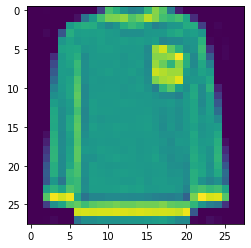

In [4]:
usage_example()

In [5]:
import sklearn
train_images, train_labels, test_images, test_labels = load_fashion_mnist()

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
#These are completely balanced
r = [0,1,2,3,4,5,6,7,8,9,10]
np.histogram(train_labels, bins=r)

(array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [8]:
from numpy import linalg as LA
from scipy import stats
def compute_distances(train_X, test_example):
    """
    Returns a vector of the distances between the given test_example
    and every training example in the matrix train_X.
    
    Parameters:
        train_X - an nx3 matrix, containing n training examples
        test_examples - a 1x3 vector containing a test example to classify
        
    Returns:
        An nx1 matrix containing the distances from test_example to all the
        examples in train_X.
    """
    
    return LA.norm(train_X - test_example, ord=1, axis=1)

def predict_one(distances, y_train, k):
    """
    Given a vector of distances between a test example and all the training examples,
    makes a prediction using a majority vote of k nearest neighbors.
    
    Parameters:
        distances - an nx1 matrix containing the distances from a test example to
                    all training examples.
        train_y - an nx1 matrix containing the true labels
        k - the number of neighbors participating in the prediction
        
    Returns:
        A classification for the test example in question (i.e., either a 0 or a 1).
    """
    result = np.argpartition(distances,k)[:k]
    classification = y_train[result]
    return stats.mode(classification, axis=None)[0][0]

def predict_all(X_train, y_train, X_test, k):
    """
    Makes a k-NN prediction for every example in X_test, using (X_train, y_train).
    
    Parameters:
        X_train - matrix of training data
        y_train - vector of training labels
        X_test - matrix of test data to be classified
        k - the number of nearest neighbors participating in the classification.
        
    Returns:
        An nx1 matrix of predictions for every test case.
    """
    y_preds = []
    for ex in X_test:
        distances = compute_distances(X_train, ex)
        p = predict_one(distances, y_train, k)
        y_preds.append(p)
    return y_preds

In [ ]:
tI = train_images[:1000]
tL = train_labels[:1000]
teI = test_images[:1000]
teL = test_labels[:1000]
from sklearn.metrics import confusion_matrix, f1_score

In [15]:
scaled_tI = train_images/255.0
scaled_teI = test_images/255.0

In [10]:
import numpy as np
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_images, train_labels)
preds_dummy = dummy_clf.predict(test_images)
dummy_clf.score(test_images, test_labels)

0.106

In [ ]:
def convert_to_binary(image):
    binary = np.zeros(image.shape)
    for i in range(0,image.shape[0]):
        if image[i] > 128 :
            binary[i] = 1
    return binary

def all_to_binary(images):
    binary = []
    for image in images:
        binary.append(convert_to_binary(image))
    return np.array(binary)

In [ ]:
#binary training
tIb = all_to_binary(train_images)
teIb = all_to_binary(test_images)
tIb5 = tIb[:1000]
teIb5 = teIb[:1000]

In [ ]:
#Non binary with our KNN Implementation
preds = predict_all(tI, tL, teI, 5)
print("Non-Binary Values")
print(confusion_matrix(teL, preds))
print(f1_score(teL, preds, average='micro'))

In [ ]:
#Binary values with our KNN Implementation
predsb = predict_all(tIb5, tL, teIb5, 5)
print("Binary Values")
print(confusion_matrix(teL, predsb))
print(f1_score(teL, predsb, average='micro'))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(teL, predsb))

Change around the k value

In [ ]:
scores = []
for k in range(1,35,2):
    preds = predict_all(tIb5, tL, teIb5, k)
    scores.append(f1_score(teL, preds, average='micro'))

plt.xlabel('K Values')
plt.ylabel('F1 Score')
plt.title('FMNIST Binary')
plt.plot(np.arange(1,35,2),scores, "o-")

In [ ]:
scores = []
for k in range(1,35,2):
    preds = predict_all(tI, tL, teI, k)
    scores.append(f1_score(teL, preds, average='micro'))

plt.xlabel('K Values')
plt.ylabel('F1 Score')
plt.title('FMNIST Normal')
plt.plot(np.arange(1,35,2),scores, "o-")

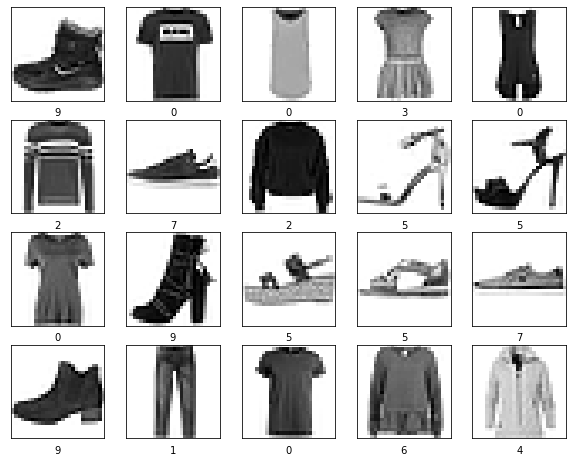

In [18]:
#Plotting figures 
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [16]:
#implementation of the scikit k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(scaled_tI, train_labels)
#params = neigh.get_params(deep=True)

preds1 = neigh.predict(scaled_teI)

accuracy_score(test_labels, preds1)

0.8554

In [ ]:
scores = []
for k in range(1,35,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(tIb, train_labels)
    preds = neigh.predict(teIb)
    scores.append(accuracy_score(test_labels, preds))

plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('FMNIST SciKit')
plt.plot(np.arange(1,35,2),scores, "o-")
print("Binary accuracy of models:", scores)

In [ ]:
scoresNonB = []
for k in range(1,35,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_images, train_labels)
    preds = neigh.predict(test_images)
    scoresNonB.append(accuracy_score(test_labels, preds))

plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('FMNIST SciKit')
plt.plot(np.arange(1,35,2),scoresNonB, "o-")
print("Non-Binary accuracy of models:", scoresNonB)

In [ ]:
#comparing actual positives to false positives, with its accuracy score
print(confusion_matrix(test_labels, preds1))
print(accuracy_score(test_labels, preds1))

In [ ]:
#break down of the accuracy of each label for knn 
print(classification_report(test_labels, preds1))

In [17]:
#implementation of the logistic regression
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(random_state=0)
logReg.fit(scaled_tI, train_labels)
pr = logReg.predict(scaled_teI)
print(accuracy_score(test_labels, pr))
#Actually pretty good accuracy, comparable to the knn model

0.8439


/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logReg = LogisticRegression(random_state=0)
logReg.fit(tIb, train_labels)
pr = logReg.predict(teIb)
print(accuracy_score(test_labels, pr))

In [ ]:
#break down of the accuracy of each label for logReg
print(classification_report(test_labels, pr))

In [ ]:
print(confusion_matrix(test_labels, pr))